In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00


In [3]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

# Датасет

In [5]:
# dataset = datasets.load_dataset("snli", split="train")
dataset = datasets.load_dataset("sentence-transformers/all-nli", "pair-score", split='train')

# there are some pairs of "premise" and "hypothesis" which haven't been
# labeled in this dataset, we will filter those out first
filtered_data = dataset.filter(lambda x: random.random() < 0.01)

len(filtered_data), filtered_data[0]

README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/942069 [00:00<?, ? examples/s]

(9366,
 {'sentence1': 'A woman is walking across the street eating a banana, while a man is following with his briefcase.',
  'sentence2': 'two coworkers cross pathes on a street',
  'score': 0.5})

In [6]:
train_data = filtered_data[:int(len(filtered_data)*0.7)]
val_data = filtered_data[int(len(filtered_data)*0.7):]

In [7]:
len(train_data['sentence1']), len(val_data['sentence1'])

(6556, 2810)

In [8]:
%%time

MAX_LENGTH = 128

tokenized_texts_train = tokenizer(train_data["sentence1"],
                            train_data["sentence2"],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

tokenized_texts_val = tokenizer(val_data["sentence1"],
                            val_data["sentence2"],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 1.62 s, sys: 182 ms, total: 1.8 s
Wall time: 1.8 s


In [9]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "scores": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])


In [19]:
sts_dataset_train = StsDataset(tokenized_texts_train, train_data['score'])
sts_dataset_val = StsDataset(tokenized_texts_val, val_data['score'])

In [20]:
batch_size = 16
dataloaders = {'train': DataLoader(sts_dataset_train, batch_size=batch_size, shuffle=False),
               'val': DataLoader(sts_dataset_val, batch_size=batch_size, shuffle=False),
              }

# Модель

In [26]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(model_name)
        # self.bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the CLS token's output
        logits = self.linear(pooled_output)
        return self.sigmoid(logits).squeeze(-1)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossEncoderBert().to(device)

# Обучение

In [28]:
#  optimizer, lr, num_warmup steps have been picked from the paper

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# total_steps = len(train_data) // batch_size
# warmup_steps = int(0.1 * total_steps)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
#                                             num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [29]:
EPOCHS = 10
train_loss = []
val_loss = []


for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    print('-------------')

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      print(f"{phase}")

      total_loss = 0
      for batch in tqdm(dataloaders[phase]):
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
              yhat = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))

              loss = loss_fn(yhat, batch["scores"].to(device))

              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()

          total_loss += loss.item() * batch['input_ids'].size(0)

      if phase == 'train':
        train_loss.append(total_loss / 6521)
        print(f"Epoch {epoch+1}, Loss: {total_loss / 6521:.4f}")
      else:
        val_loss.append(total_loss / 2795)
        print(f"Epoch {epoch+1}, Loss: {total_loss / 2795:.4f}")


Epoch 1/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.66it/s]


Epoch 1, Loss: 0.1716
val


100%|██████████| 176/176 [00:09<00:00, 19.19it/s]


Epoch 1, Loss: 0.1672
Epoch 2/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.62it/s]


Epoch 2, Loss: 0.1695
val


100%|██████████| 176/176 [00:09<00:00, 19.20it/s]


Epoch 2, Loss: 0.1660
Epoch 3/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.62it/s]


Epoch 3, Loss: 0.1691
val


100%|██████████| 176/176 [00:09<00:00, 19.25it/s]


Epoch 3, Loss: 0.1655
Epoch 4/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.64it/s]


Epoch 4, Loss: 0.1690
val


100%|██████████| 176/176 [00:09<00:00, 19.19it/s]


Epoch 4, Loss: 0.1653
Epoch 5/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.63it/s]


Epoch 5, Loss: 0.1689
val


100%|██████████| 176/176 [00:09<00:00, 19.18it/s]


Epoch 5, Loss: 0.1653
Epoch 6/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.63it/s]


Epoch 6, Loss: 0.1687
val


100%|██████████| 176/176 [00:09<00:00, 19.22it/s]


Epoch 6, Loss: 0.1653
Epoch 7/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.63it/s]


Epoch 7, Loss: 0.1687
val


100%|██████████| 176/176 [00:09<00:00, 19.16it/s]


Epoch 7, Loss: 0.1653
Epoch 8/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.63it/s]


Epoch 8, Loss: 0.1687
val


100%|██████████| 176/176 [00:09<00:00, 19.25it/s]


Epoch 8, Loss: 0.1653
Epoch 9/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.63it/s]


Epoch 9, Loss: 0.1686
val


100%|██████████| 176/176 [00:09<00:00, 19.23it/s]


Epoch 9, Loss: 0.1653
Epoch 10/10
-------------
train


100%|██████████| 410/410 [01:12<00:00,  5.62it/s]


Epoch 10, Loss: 0.1687
val


100%|██████████| 176/176 [00:09<00:00, 19.30it/s]

Epoch 10, Loss: 0.1653


# Графики обучения

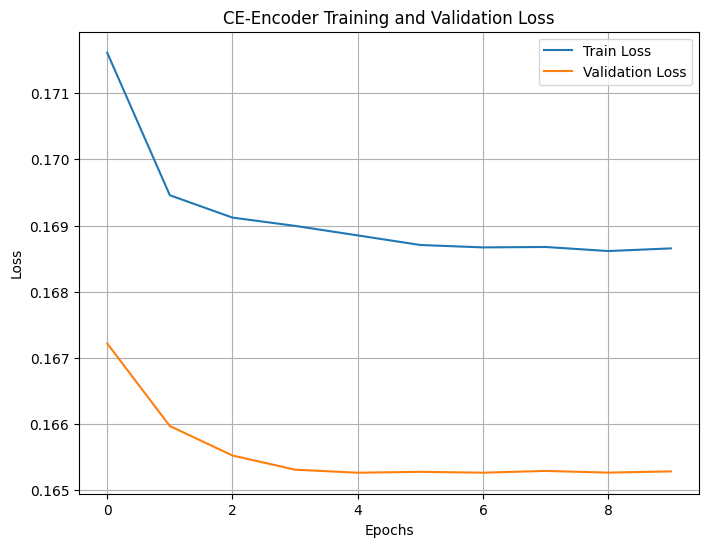

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CE-Encoder Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [32]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Генерация в NLP/models/CE_model/CE_model.pth")